<a href="https://colab.research.google.com/github/HaaLeo/vague-requirements-scripts/blob/resampling-in-feature-space/colab-notebooks/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify requirements as vague or not using [ktrain](https://github.com/amaiya/ktrain) and tensorflow


## Install dependencies
*ktrain* requires TensorFlow 2.1. See [amaiya/ktrain#151](https://github.com/amaiya/ktrain/issues/151).
Further we install a forked version of eli5lib to gain insights in the model's decision process and some self built helper functions to preprocess MTurk result files.

In [11]:
!pip3 install -q -U tensorflow_gpu==2.1.0 ktrain==0.17.5 imbalanced-learn==0.5.0
!pip3 install -q -U git+https://github.com/HaaLeo/vague-requirements-scripts
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

     |████████████████████████████████| 174kB 6.5MB/s 


Check versions and enable logging

In [12]:
import tensorflow as tf
import ktrain
import imblearn
assert tf.__version__ == '2.1.0'
assert ktrain.__version__ == '0.17.5'
assert imblearn.__version__ == '0.5.0'

import logging
import sys

logging.basicConfig(
    format='%(asctime)s [%(name)-20.20s] [%(levelname)-5.5s]  %(message)s',
    stream=sys.stdout,
    level=logging.INFO)

LOGGER = logging.getLogger('colab-notebook')
LOGGER.info('Hello from colab notebook')

2020-07-07 15:45:20,966 [__main__            ] [INFO ]  Hello from colab notebook


Using TensorFlow backend.


## Set Parameters
Set the parameters for this run.
Ktrain ignores `max_features` and `ngram_range` in v0.17.5, see [amaiya/ktrain/issues#190](https://github.com/amaiya/ktrain/issues/190)

In [187]:
DATA_FILE_NAMES = [f'corpus-batch-{i}-mturk.csv' for i in range(5)] + ['corpus-batch-5-27-mturk.csv']

RANDOM_STATE = 1 # for seeding

UPSAMPLING_STRATEGY = 'random_downsampling' # resample_with_replacement, SMOTE or random_downsampling
TRAIN_VAL_TEST_PROPORTION = [0.8, 0.1, 0.1] # [TestProportion, ValProportion, TestProportion]

LEARNING_RATE = 2e-5
EPOCHS = 4
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 256
BATCH_SIZE = 6
MAX_FEATURES = 35_000
NGRAM_RANGE = 2

CLASS_NAMES = ['not-vague', 'vague'] # 0=not-vague 1=vague

PREPROCESS_MODE = 'distilbert'
LOGGER.info('Set parameter successfully')

2020-07-07 19:07:38,378 [__main__            ] [INFO ]  Set parameter successfully


## Load Dataset

### Mount Google Drive
Mount the google drive to access the dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load Dataset Into Arrays

In [13]:
from vaguerequirementslib import read_csv_files, build_confusion_matrix, calc_majority_label
import pandas as pd

def read_drive_data(files_list: list, separator: str) -> pd.DataFrame:
    """
    Calculate the majority label for the given source file list

    Args:
        files_list (list): The CSV files to calculate the majority label for
        separator (str): The CSV separator
        drop_ties (bool): If there is a tie in votes (e.g.: One votes for vague one for not vague) then drop this entry from the confusion matrix.

    Returns:
        pd.DataFrame: The dataframe containing the majority label.
    """
    frame = read_csv_files(files_list, separator)
    confusion_matrix = build_confusion_matrix(frame, drop_ties=True)
    return calc_majority_label(confusion_matrix)

# Read all data
df = read_drive_data(
    [f'/content/drive/My Drive/datasets/corpus/labeled/{file_name}' for file_name in DATA_FILE_NAMES],
    ','
  )
df.head()
df_vague_count = int(df[df.majority_label == 1].majority_label.value_counts())
df_not_vague_count = int(df[df.majority_label == 0].majority_label.value_counts())
LOGGER.info(f'Data frame consists of {df_vague_count} vague data points and {df_not_vague_count} not vague data points.')

2020-07-07 15:45:37,238 [vaguerequirementslib] [INFO ]  Build confusion matrix.
2020-07-07 15:45:37,635 [vaguerequirementslib] [INFO ]  Dropped 638 requirements due to ties.
2020-07-07 15:45:37,638 [vaguerequirementslib] [INFO ]  Built confusion matrix including 1082 of 1720 requirements. 
2020-07-07 15:45:37,640 [vaguerequirementslib] [INFO ]  Overall "vague" votes count = 388. Overall "not vague" votes count = 1494
2020-07-07 15:45:37,691 [vaguerequirementslib] [INFO ]  "vague" majority label count = 237. "not vague" majority label count = 845.
2020-07-07 15:45:37,698 [__main__            ] [INFO ]  Data frame consists of 237 vague data points and 845 not vague data points.


### Split data set


In [179]:
from typing import Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

from ktrain import text as txt
from ktrain.text.preprocessor import TransformerDataset

def resample(x, y, strategy: str = None) -> Tuple:
    """
    Resample the given dataframe to contain equally much samples of vague and not-vague requirements.

    Args:
        x
        y
        strategy (str): The resampling strategy to use either "resample_with_replacement", "SMOTE" "random_downsampling" or None.

    Returns:
        Tuple: The upsampled data.
    """
    if strategy:
        if strategy == 'resample_with_replacement':
            sampler = RandomOverSampler(sampling_strategy=1., random_state=RANDOM_STATE)
        elif strategy == 'SMOTE':
            sampler = SMOTE(sampling_strategy=1., random_state=RANDOM_STATE, n_jobs=-1, k_neighbors=5)
        elif strategy == 'random_downsampling':
            sampler = RandomUnderSampler(sampling_strategy=1., random_state=RANDOM_STATE)
            LOGGER.info('hello from sampling')
        x_new, y_new = sampler.fit_resample(x, y)
        # print('hello upsampling')
        # print(x_new.shape)
        # print(y_new.shape)
        # print(y_new)
        LOGGER.info(f'Resampled dataset with strategy"{strategy}": label proportion="{np.sum(y_new, axis=0)[0]}/{np.sum(y_new, axis=0)[0]}".')  
        result = (x_new, y_new)
        
    else: 
        LOGGER.warning('Data frame will not be upsampled, because no strategy was provided.')
        result = (x, y)
    return result


def split_dataset(data_frame: pd.DataFrame, train_val_test_proportion: Tuple[float, float, float]) -> Tuple[List[str], List[int], List[str], List[int], List[str], List[int]]:
    """
    Split the dataset into training, validation and test set.

    Args:
        data_frame (pd.DataFrame): The data frame to generate the data sets from.

    Returns:
        Tuple[List[str], List[int], List[str], List[int], List[str], List[int]]: x_train, y_train, x_val, y_val, x_test, y_test
    """
    train_proportion, val_proportion, test_proportion = train_val_test_proportion

    train_df, val_test_df = train_test_split(data_frame, test_size=(1-train_proportion), random_state=RANDOM_STATE, stratify=data_frame['majority_label'])

    val_df, test_df = train_test_split(val_test_df, test_size=test_proportion/(test_proportion+val_proportion), random_state=RANDOM_STATE, stratify=val_test_df['majority_label'])


    return train_df, val_df, test_df


def preprocess_data(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, upsampling_strategy=None) -> Tuple:
    def _preprocess(my_df: pd.DataFrame) -> Tuple:
        dummy_df = pd.DataFrame.from_dict({'requirement': ['foo', 'bar'], 'majority_label': [0, 1]})
        return txt.texts_from_df(my_df, text_column='requirement', label_columns=['majority_label'], val_df=dummy_df,  max_features=MAX_FEATURES, maxlen=MAX_LEN,  ngram_range=NGRAM_RANGE, preprocess_mode=PREPROCESS_MODE, random_state=RANDOM_STATE)
    
    train_data, _, _ = _preprocess(train_df)
    val_data, _, _ = _preprocess(val_df)
    test_data, _, test_preproc = _preprocess(test_df)

    # Change shape to 2D for sampler
    orig_x_shape = train_data.x.shape
    orig_y_shape = train_data.y.shape

    # Resample training set
    x_new, y_new = resample(
        np.reshape(train_data.x, (orig_x_shape[0], orig_x_shape[1]*orig_x_shape[2])), 
        train_data.y, 
        upsampling_strategy)
    
    # Resampling reduces the dimension size
    y_new =[[0. if element == 1 else 1., float(element)] for element in y_new ]
    
    # Create again a TransformerDataset
    train_data = TransformerDataset(np.reshape(x_new, (x_new.shape[0], orig_x_shape[1], orig_x_shape[2])), y_new)


    return train_data, val_data, test_data, test_preproc

# Split the data set
train_df, val_df, test_df = split_dataset(df, TRAIN_VAL_TEST_PROPORTION)

# Calc counts
train_df_vague_count = int(train_df[train_df.majority_label == 1].majority_label.value_counts())
train_df_not_vague_count = int(train_df[train_df.majority_label == 0].majority_label.value_counts())
val_df_vague_count = int(val_df[val_df.majority_label == 1].majority_label.value_counts())
val_df_not_vague_count = int(val_df[val_df.majority_label == 0].majority_label.value_counts())
test_df_vague_count = int(test_df[test_df.majority_label == 1].majority_label.value_counts())
test_df_not_vague_count = int(test_df[test_df.majority_label == 0].majority_label.value_counts())

LOGGER.info(f'Training dataset: vague count="{train_df_vague_count}", not vague count="{train_df_not_vague_count}"')
LOGGER.info(f'Validation dataset: vague count="{val_df_vague_count}", not vague count="{val_df_not_vague_count}"')
LOGGER.info(f'Test dataset: vague count="{test_df_vague_count}", not vague count="{test_df_not_vague_count}"')

# Preprocess for Transfer Learning
train_data, val_data, test_data, test_preproc = preprocess_data(train_df, val_df, test_df, UPSAMPLING_STRATEGY)

2020-07-07 19:01:56,176 [__main__            ] [INFO ]  Training dataset: vague count="189", not vague count="676"
2020-07-07 19:01:56,177 [__main__            ] [INFO ]  Validation dataset: vague count="24", not vague count="84"
2020-07-07 19:01:56,178 [__main__            ] [INFO ]  Test dataset: vague count="24", not vague count="85"
preprocessing train...
language: en
train sequence lengths:
	mean : 22
	95percentile : 42
	99percentile : 63


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:229: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  'If this is a sentence pair classification task, please cast to tuple.')


preprocessing train...
language: en
train sequence lengths:
	mean : 22
	95percentile : 43
	99percentile : 58


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


preprocessing train...
language: en
train sequence lengths:
	mean : 23
	95percentile : 40
	99percentile : 55


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 1
	95percentile : 1
	99percentile : 1


2020-07-07 19:01:58,152 [__main__            ] [INFO ]  hello from sampling
2020-07-07 19:01:58,157 [__main__            ] [INFO ]  Resampled dataset with strategy"random_downsampling": label proportion="189/189".


## STEP 1:  Create a Transformer Model and Train it

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

In [188]:
# Create the transformer
t = txt.Transformer(MODEL_NAME, maxlen=MAX_LEN, class_names=CLASS_NAMES)
t.preprocess_train_called = True # Simulate call to preprocess_train()

# Get the model and learner
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=BATCH_SIZE)

# Find a suitable learning rate
# learner.lr_find(show_plot=True, start_lr=1e-09, max_epochs=EPOCHS)
# print(learner.lr_estimate())



begin training using onecycle policy with max lr of 2e-05...
Train for 63 steps, validate for 4 steps
Epoch 1/4
63/63 [==============================] - 20s 319ms/step - loss: 0.6899 - accuracy: 0.5291 - val_loss: 0.6784 - val_accuracy: 0.6481
Epoch 2/4
63/63 [==============================] - 12s 196ms/step - loss: 0.6780 - accuracy: 0.5608 - val_loss: 0.7240 - val_accuracy: 0.4167
Epoch 3/4
63/63 [==============================] - 12s 198ms/step - loss: 0.5950 - accuracy: 0.6958 - val_loss: 0.6047 - val_accuracy: 0.6481
Epoch 4/4
63/63 [==============================] - 12s 197ms/step - loss: 0.4149 - accuracy: 0.8386 - val_loss: 0.6501 - val_accuracy: 0.6111


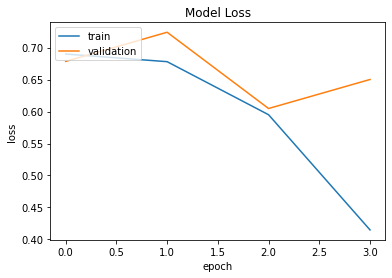

2020-07-07 19:08:50,255 [__main__            ] [INFO ]  Successfully trained model.


In [189]:
from datetime import datetime
from pytz import timezone

# For every triggered fitting run create a new directory where the results will be saved
now = datetime.now(timezone('Europe/Berlin'))
result_dir = f'/content/drive/My Drive/runs/{now.strftime("%Y-%m-%d/%H-%M-%S")}'

# Fit the model
learning_history = learner.fit_onecycle(LEARNING_RATE, EPOCHS).history
learner.plot('loss')

LOGGER.info('Successfully trained model.')

## STEP 2: Evaluate the model
Evaluate the model using the `test_data`.

              precision    recall  f1-score   support

   not-vague       0.88      0.74      0.80        85
       vague       0.41      0.62      0.49        24

    accuracy                           0.72       109
   macro avg       0.64      0.68      0.65       109
weighted avg       0.77      0.72      0.73       109

[[63 22]
 [ 9 15]]


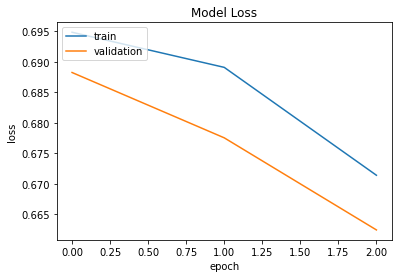

2020-07-07 19:07:13,937 [__main__            ] [INFO ]  Successfully validated test set.


In [186]:
train_result = learner.validate(class_names=t.get_classes(), val_data=train_data, print_report=False)
val_result = learner.validate(class_names=t.get_classes(), val_data=val_data, print_report=False)
test_result = learner.validate(class_names=t.get_classes(), val_data=test_data)
print(test_result)
learner.plot('loss')
LOGGER.info('Successfully validated test set.')

## STEP 3: Gather Results

Gather results, calulate metrics and write them to the drive.

In [149]:
import os
import json
from os import path

from vaguerequirementslib import TP, TN, FP, FN, calc_all_metrics

def build_result_data(test_result: List) -> dict:
    result_data = {
        'metrics':{
            'train': {
                'vague': {
                    TP: int(train_result[1][1]),
                    FP: int(train_result[0][1]),
                    TN: int(train_result[0][0]),
                    FN: int(train_result[1][0])
                },
                'not_vague': {
                    TP: int(train_result[0][0]),
                    FP: int(train_result[1][0]),
                    TN: int(train_result[1][1]),
                    FN: int(train_result[0][1])
                }
            },
            'validation': {
                'vague': {
                    TP: int(val_result[1][1]),
                    FP: int(val_result[0][1]),
                    TN: int(val_result[0][0]),
                    FN: int(val_result[1][0])
                },
                'not_vague': {
                    TP: int(val_result[0][0]),
                    FP: int(val_result[1][0]),
                    TN: int(val_result[1][1]),
                    FN: int(val_result[0][1])
                }
            },
            'test': {
                'vague': {
                    TP: int(test_result[1][1]),
                    FP: int(test_result[0][1]),
                    TN: int(test_result[0][0]),
                    FN: int(test_result[1][0])
                },
                'not_vague': {
                    TP: int(test_result[0][0]),
                    FP: int(test_result[1][0]),
                    TN: int(test_result[1][1]),
                    FN: int(test_result[0][1])
                }
            }
        },
        'misc': {   
            'random_state': RANDOM_STATE,
            'learning_history': learning_history
        },
        'data_set':{
            'summary': {
                'data_files': DATA_FILE_NAMES,
                'vague_data_points': df_vague_count,
                'not_vague_data_points': df_not_vague_count,
            },
            'train': {
                'upsampling_strategy': UPSAMPLING_STRATEGY,
                'proportion': TRAIN_VAL_TEST_PROPORTION[0],
                'vague_data_points': train_df_vague_count,
                'not_vague_data_points': train_df_not_vague_count
            },
            'validation': {
                'proportion': TRAIN_VAL_TEST_PROPORTION[1],
                'vague_data_points': val_df_vague_count,
                'not_vague_data_points': val_df_not_vague_count
            },
            'test': {
                'proportion': TRAIN_VAL_TEST_PROPORTION[2],
                'vague_data_points': test_df_vague_count,
                'not_vague_data_points': test_df_not_vague_count
            }
        },
        'hyperparameter': {
            'learning_rate': LEARNING_RATE,
            'epochs': EPOCHS,
            'model_name': MODEL_NAME,
            'max_len': MAX_LEN,
            'batch_size': BATCH_SIZE,
            'max_features': MAX_FEATURES,
            'ngram_range': NGRAM_RANGE,
        }
    }

    for key in result_data['metrics']:
        result_data['metrics'][key]['not_vague'].update(calc_all_metrics(**result_data['metrics'][key]['not_vague']))
        result_data['metrics'][key]['vague'].update(calc_all_metrics(**result_data['metrics'][key]['vague']))
    
    return result_data

result_data = build_result_data(test_result)
# Get the predictor
predictor = ktrain.get_predictor(learner.model, preproc=t)
LOGGER.info('Successfully built result data.')

2020-07-07 18:38:19,841 [__main__            ] [INFO ]  Successfully built result data.


## STEP 3.1 Save the Results
Check out the [FAQ](https://github.com/amaiya/ktrain/blob/master/FAQ.md#method-1-using-predictor-api-works-for-any-model) for how to load a model from a predictor.

In [ ]:
import os

# Save the corresponding model (predictor)
predictor.save(path.join(result_dir, 'predictor'))

# Save the evaluation result (test_data results)
os.makedirs(result_dir, exist_ok=True)
with open(path.join(result_dir, 'evaluation.json'), mode='w', encoding='utf-8') as json_file:
    json.dump(result_data, json_file, indent=4,)
LOGGER.info(f'Successfully saved result data to directory="{result_dir}".')

2020-07-07 09:14:19,872 [MainThread          ] [INFO ]  Successfully saved result data to directory="/content/drive/My Drive/runs/2020-07-07/09-53-12".


## STEP 4 Inspect the Model and its Losses

Let's examine the validation example about which we were the most wrong.

In [162]:
learner.view_top_losses(n=4, preproc=t, val_data=test_data)
top_losses = learner.top_losses(n=4, preproc=t, val_data=test_data)

----------
id:43 | loss:2.07 | true:vague | pred:not-vague)

----------
id:5 | loss:1.95 | true:vague | pred:not-vague)

----------
id:49 | loss:1.84 | true:vague | pred:not-vague)

----------
id:36 | loss:1.81 | true:vague | pred:not-vague)



In [151]:
top_loss_req = test_df.iloc[11]['requirement'] # Requirement that produces top loss

print(predictor.predict(top_loss_req))

# predicted probability scores for each category
print(predictor.predict_proba(top_loss_req))
print(top_loss_req)

not-vague


[0.9684988  0.03150119]
When capacitors are to be used in circuits operating between 10 KHz and 100 KHz, equivalent series resistance measurements shall be read and recorded during Group A testing on a 100% basis for data collection.


Let's invoke the `explain` method to see which words contribute most to the classification.

In [163]:
from IPython.core.display import display

for id, _, _, _ in top_losses:
    top_loss_req = test_df.iloc[id]['requirement'] # Requirement that produces top loss
    display(predictor.explain(top_loss_req, n_samples=1_000))

The words in the darkest shade of green contribute most to the classification and agree with what you would expect for this example.